In [24]:
import numpy as np
import numpy.random as rd
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

We define the function $f$:

In [25]:
def f(u):
    return np.cos(2 * np.pi * (np.mean(u) - 1/2))

Notice that $I := \int_{[0, 1]^d} f(u) du = \mathbb{E}_{U \sim \mathcal{U}([0, 1]^d)}[f(U)]$. Thus, we can approximate $I$ using Monte Carlo.

In [26]:
def montecarlo(d, N = 10000):
    """
    Estimates the expected value of a function using the Monte Carlo method.

    Parameters:
    - d: The dimension of the random input vector. It determines the size of 
         the array generated by `np.random.random(d)`.
    - N: The number of Monte Carlo simulations (default is 10,000).

    Returns:
    - The empirical mean of the function evaluations, approximating the expected value.
    """

    X = [f(rd.random(d)) for _ in range(N)]
    return np.mean(X)

Here are the results for different values of `N`:

In [27]:
d_values = [1, 2, 3, 5, 10, 100]
N_values = [100, 1000, 10000]

data = {N: [montecarlo(d, N) for d in d_values] for N in N_values}

df = pd.DataFrame(data, index = d_values)
df.iloc[:len(d_values)]

,100,1000,10000
1,0.084218,-0.004971,-0.003149
2,0.364287,0.418352,0.407162
3,0.581171,0.574880,0.572903
5,0.724527,0.708967,0.719013
10,0.846945,0.848424,0.847105
100,0.984413,0.983857,0.983809


For quasi-MC and for $d > 1$, like in the course slides, we need to generate the $u_n$'s so that so that exactly one point falls in each horizontal or vertical strip of $\left\{\frac{1}{2N}, \frac{3}{2N}, \dots, \frac{2N - 1}{2N}\right\}^d$. For this we use the following function:

In [28]:
def generate_indices(d, N = 10000):
    list_indices = []
    X = []
    arr = np.array(list(range(N)))
    perm = [rd.permutation(arr) for _ in range(d- 1)]
    for i in range(N):
        indices = [i] + [perm[j][i] for j in range(d - 1)]
        list_indices.append(indices)
    list_indices = np.array(list_indices)
    list_indices = (2 * list_indices + 1)/(2 * N)
    return list_indices

Case $d = 2$: this is what `generate_indices(2, 10)` corresponds to:

[[0.05 0.75]
 [0.15 0.85]
 [0.25 0.15]
 [0.35 0.35]
 [0.45 0.65]
 [0.55 0.25]
 [0.65 0.05]
 [0.75 0.45]
 [0.85 0.55]
 [0.95 0.95]]


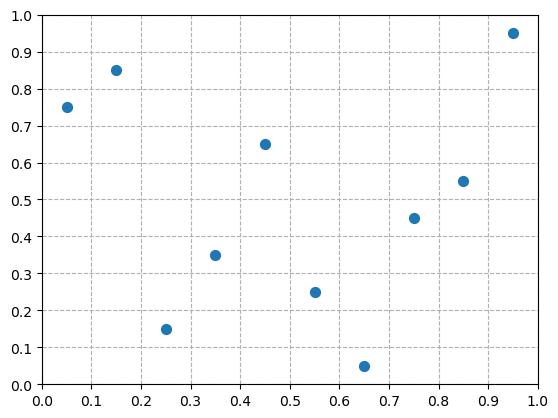

In [29]:
points = generate_indices(2, 10)

print(points)

x = points[:, 0]
y = points[:, 1]

plt.scatter(x, y, s = 50)
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))
plt.grid(True, linestyle = '--')
plt.show()

Case $d = 3$: this is what `generate_indices(3, 10)` corresponds to:

[[0.05 0.45 0.55]
 [0.15 0.25 0.85]
 [0.25 0.15 0.75]
 [0.35 0.75 0.05]
 [0.45 0.55 0.15]
 [0.55 0.95 0.45]
 [0.65 0.05 0.35]
 [0.75 0.35 0.95]
 [0.85 0.65 0.65]
 [0.95 0.85 0.25]]


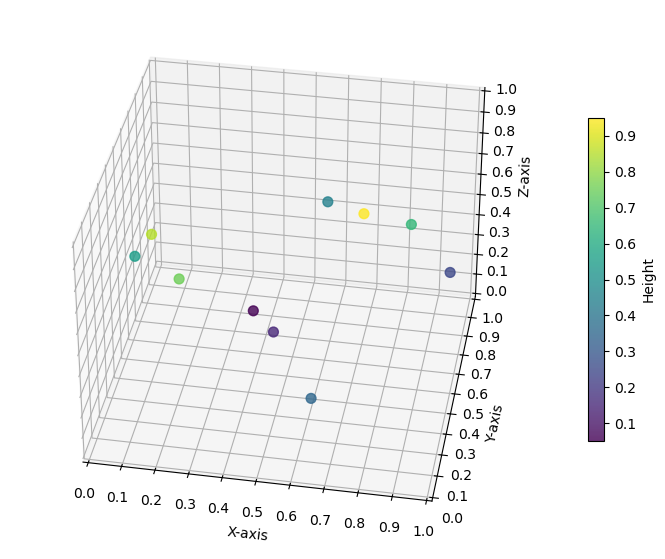

In [30]:
points = generate_indices(3, 10)

print(points)

x = points[:, 0]
y = points[:, 1]
z = points[:, 2]

fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot(111, projection = '3d')

# Grid
ax.set_xticks(np.linspace(0, 1, 11))
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_zticks(np.linspace(0, 1, 11))
ax.grid(True, linestyle = '--')

# Point of view
ax.view_init(elev = 35, azim = -80)

# The color is a function of height
sc = ax.scatter(x, y, z,
                c = z,
                cmap = 'viridis',
                s = 50,
                alpha = 0.8)
cbar = plt.colorbar(sc, ax = ax, shrink = 0.6)
cbar.set_label("Height")

# Label of each axes
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

plt.show()

We use the function `generate_indices()` to generate a vector $X = (f(u_1), \dots, f(u_N))$ and we return the mean of $X$.

In [31]:
def quasimontecarlo(d, N = 10000):
    if d == 1:
        X = [f((2 * n + 1)/(2 * N)) for n in range(N)]
    if d > 1:
        list_indices = generate_indices(d, N)
        X = [f(u) for u in list_indices]
    return np.mean(X)

For $d = 1$, we have $I = \int_0^1 \cos\left(2 \pi \left(u - \frac{1}{2}\right)\right) du = \frac{1}{2\pi} \int_{-\pi}^\pi \cos(t) dt = 0$. We can see below that quasi-MC is much better than MC.

In [32]:
float(montecarlo(1)), float(quasimontecarlo(1))

(-0.0077326398621778, 4.5474735088646414e-17)

For $d > 1$: bon ça marche mais c'est trop bizarre car c'est à peu du même ordre que MC...

In [258]:
m1 = np.mean([montecarlo(2) for _ in range(10)])
m2 = np.mean([quasimontecarlo(2) for _ in range(10)])
v1 = np.var([montecarlo(2) for _ in range(10)])
v2 = np.var([quasimontecarlo(2) for _ in range(10)])
float(m1), float(m2), float(v1), float(v2)

(0.40456674153625033,
 0.40595810612245564,
 2.7097415536299998e-05,
 3.0007189282760058e-05)

* Question 2

Implementing the first Haber's estimator 

In [172]:
# Define the set of the centres of the k^d hypercubes
import itertools
def c_0k(d, k):
    return np.array([[(2*j + 1) / (2*k) for j in point] for point in itertools.product(range(k), repeat=d)])


In [ ]:
c_0k(2, 5)

array([[0.1, 0.1],
       [0.1, 0.3],
       [0.1, 0.5],
       [0.1, 0.7],
       [0.1, 0.9],
       [0.3, 0.1],
       [0.3, 0.3],
       [0.3, 0.5],
       [0.3, 0.7],
       [0.3, 0.9],
       [0.5, 0.1],
       [0.5, 0.3],
       [0.5, 0.5],
       [0.5, 0.7],
       [0.5, 0.9],
       [0.7, 0.1],
       [0.7, 0.3],
       [0.7, 0.5],
       [0.7, 0.7],
       [0.7, 0.9],
       [0.9, 0.1],
       [0.9, 0.3],
       [0.9, 0.5],
       [0.9, 0.7],
       [0.9, 0.9]])

In [264]:
def haber_estimator_1(d, k, N = 10000):
    c_0k_point = c_0k(d, k)
    U_c = np.random.uniform(-1/(2*k), 1/(2*k), size = (N, d))
    X = [f(u + c) for c,u in zip(c_0k_point, U_c)]
    return np.sum(X)/(k**d)


In [288]:
m = np.mean([haber_estimator_1(2,5) for _ in range(10)])
v = np.var([haber_estimator_1(2,5) for _ in range(10)])
float(m), float(v)

(0.3986039249375901, 0.0014324012415515737)